# Internal Priming

Despite the chemistry of the system clearly preventing internal priming, we wants to show definitively that there is no internal priming with ONT DRS data. So thats what we'll do. First we find all homopolymer A runs in the Arabidopsis genome, and then we'll count the number of reads that end within a window of these sequences.

In [1]:
import os, sys, glob, re, pysam, json, matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load the sequences of all Arabidopsis coding sequences in Ensembl 35
from Bio import SeqIO
from Bio.Alphabet import IUPAC
TAIR10_cds_fasta = "../../annotations/Araport/Araport11_genes.201606.cds.fasta"
cds_seqrecords = list(SeqIO.parse(TAIR10_cds_fasta, "fasta", IUPAC.unambiguous_dna))

In [3]:
# find all the polyA positions with length 6+
polyAstarts = {}
seq_records = {}
for seq_record in cds_seqrecords:
    seq_records[seq_record.id] = seq_record
    polyAs = [(m.start(0), m.end(0)) for m in re.finditer('A{6,}', str(seq_record.seq))]
    for polyA in polyAs:
        try:
            polyAstarts[seq_record.id]["polyApos"].append(polyA)
        except KeyError:
            polyAstarts[seq_record.id] = {"polyApos":[polyA]}

In [4]:
# load the annotaion
from parsing_routines.gff_gtf_tools import annotation
annot = annotation("../../annotations/Araport/Araport11_GFF3_genes_transposons.201606.gtf",
                   filetype="gtf", stripChr=True)

In [5]:
# get the coding sequence information from the nnotation. We do this outside the function because its relatively slow
# so its a good ide ato to it just once.
annot.clear_all()
annot.set_feature("CDSs")
CDSs = annot.get_selection()
lens = annot.get_selection_lengths()

def annotateGenomicPositions(thisid, CDSs, lens, polyAstarts_dic, seq_records):
    
    """Add the genomic coordinates of each polyA position for the dictionary."""
    
    def locateGenomicPosition(PASpos, theselens, theseCDSs):
        # locate start
        i = 0
        while PASpos>0:
            PASpos = PASpos - theselens[i]
            i+=1
        thisexon = theseCDSs[i-1]
        
        # note if it is a terminal exon
        terminalExon=False
        if i==len(theseCDSs):
            terminalExon=True
        
        # generate genomic position
        if thisexon.strand != "+":
            thispos = thisexon.start+abs(PASpos)-1
        else:
            thispos = thisexon.stop-abs(PASpos)
        
        return(thispos, terminalExon)
    
    theseCDSs=[]
    theselens=[]
    i=0
    while i<len(CDSs):
        CDS = CDSs[i]
        if CDS.desc['transcript_id']==thisid:
            theseCDSs.append(CDSs[i])
            theselens.append(lens[i])
        i+=1
            
    if theseCDSs[0].strand != "+":
        theseCDSs = theseCDSs[::-1]
        theselens = theselens[::-1]
    
    polyAstarts[thisid]['chrid']=theseCDSs[0].chrid

    for PASpos in polyAstarts[thisid]["polyApos"]:
        # locate start
        startpos, stexon = locateGenomicPosition(PASpos[0], theselens, theseCDSs)
        endpos, etexon = locateGenomicPosition(PASpos[1], theselens, theseCDSs)
        
        try:
            polyAstarts[thisid]["polyAgenpos"].append((startpos, endpos))
            polyAstarts[thisid]["is_inTerminalExon"].append((stexon, etexon))
        except KeyError:
            polyAstarts[thisid]["polyAgenpos"] = [(startpos, endpos)]
            polyAstarts[thisid]["is_inTerminalExon"] = [(stexon, etexon)]
    
    return(polyAstarts_dic)


In [6]:
# add the genomic coordinates for all the sites
import time
report_every = 500
Nrep=0
i=0
tstart=time.time()
for thisid in polyAstarts.keys():
    polyAstarts = annotateGenomicPositions(thisid, CDSs, lens, polyAstarts, seq_records)
    i+=1
    if i==report_every:
        Nrep+=1
        print("Processed {} CDSs in {:.2f}s...".format(Nrep*report_every, time.time()-tstart))
        i=0
        tstart=time.time()
    

Processed 500 CDSs in 102.80s...
Processed 1000 CDSs in 93.12s...
Processed 1500 CDSs in 93.12s...
Processed 2000 CDSs in 93.15s...
Processed 2500 CDSs in 93.13s...
Processed 3000 CDSs in 93.21s...
Processed 3500 CDSs in 93.15s...
Processed 4000 CDSs in 93.10s...
Processed 4500 CDSs in 93.10s...
Processed 5000 CDSs in 93.15s...
Processed 5500 CDSs in 93.18s...
Processed 6000 CDSs in 93.18s...
Processed 6500 CDSs in 93.17s...
Processed 7000 CDSs in 93.12s...
Processed 7500 CDSs in 93.10s...
Processed 8000 CDSs in 93.15s...
Processed 8500 CDSs in 93.16s...
Processed 9000 CDSs in 93.15s...
Processed 9500 CDSs in 93.16s...
Processed 10000 CDSs in 93.15s...
Processed 10500 CDSs in 93.13s...
Processed 11000 CDSs in 93.23s...
Processed 11500 CDSs in 93.19s...
Processed 12000 CDSs in 92.95s...
Processed 12500 CDSs in 91.65s...
Processed 13000 CDSs in 90.54s...
Processed 13500 CDSs in 89.60s...


## Refactoring the data to better represent what we want

This dictionary is kind-of complicated now and would benefit from being refactored to be keyed on genomic position of each poly-A internal run, I think. So lets do that.

In [7]:
new_polyAstarts={}
for thisid in polyAstarts.keys():
    posind=0
    for polyarun in polyAstarts[thisid]['polyAgenpos']:
        chrom = polyAstarts[thisid]['chrid']
        start = polyarun[0]
        end = polyarun[1]
        strand = "+"
        if start>end:
            start = polyarun[1]
            end = polyarun[0]
            strand = "-"
        region = (chrom, int(start), int(end), strand)
        if region not in new_polyAstarts.keys():
            new_polyAstarts[region] = {'is_inTerminalExon':[polyAstarts[thisid]['is_inTerminalExon'][posind]],
                                       'tx_id':[thisid],
                                       'polyApos':[polyAstarts[thisid]["polyApos"][posind]],
                                       'genomic_length':end-start,
                                       'length':[polyAstarts[thisid]["polyApos"][posind][1]-polyAstarts[thisid]["polyApos"][posind][0]]}
        else:
            new_polyAstarts[region]['is_inTerminalExon'].append(polyAstarts[thisid]['is_inTerminalExon'][posind])
            new_polyAstarts[region]['polyApos'].append(polyAstarts[thisid]['polyApos'][posind])
            new_polyAstarts[region]['tx_id'].append(thisid)
        posind+=1

In [8]:
# print a quick count of the number ol detected poly-A runs
print("Located {:d} pA6 runs.".format(len(new_polyAstarts.keys())))

Located 10844 pA6 runs.


## Cross-referencing with the ONT DRS reads

OK, with the poly-A run infor dissected its time to load the reads and cross reference. Although this is somewhat parallelized in the code below it still takes ~4ks (~1hrs) to run.

In [9]:
# Datasets
bam_files = {"col0_rep1":{"bamfile":"201901_col0_2916.bam",
                          "path":"../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq"},
             "col0_rep2a":{"bamfile":"201903_col0_2917_exp2.bam",
                          "path":"../../datasets/20180405_FAH59362_WT_Col0_2917"},
             "col0_rep2b":{"bamfile":"201901_col0_2917.bam",
                          "path":"../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917"},
             "col0_rep3":{"bamfile":"201901_col0_2918.bam",
                          "path":"../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918"},
             "col0_rep4":{"bamfile":"201901_col0_2919.bam",
                          "path":"../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919"},
             "col0_5padapter_rep1":{"bamfile":"201902_col0_2916_5adapter_exp2.bam",
                                    "path":"../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916"},
             "col0_5padapter_rep2":{"bamfile":"201902_col0_2918_5adapter.bam",
                                    "path":"../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918"}}

bamfiles=[]
for keystr in bam_files.keys():
    fullpath = os.path.join(bam_files[keystr]["path"], "aligned_data/TAIR10/",
                            bam_files[keystr]["bamfile"])
    bamfiles.append(fullpath)

In [10]:
def findInternalPrimingReads(jobid, bamfile, PAS, padding=int(20)):
    
    """ find reads in a set of bamfiles that have end positions matching the polyA runs in CDSs"""
    
    # setup temp data store
    import pickle, time, re
    tfilename = 'polyAstarts_{}.pkl'.format(jobid)
    output = open(tfilename, 'wb')
    
    t0=time.time()
    print("Processing {}...".format(bamfile))
    thisbam = pysam.AlignmentFile(bamfile,"rb")
    matchedreads=0
    filereads=0
    posmatches=0
    this_results={}
    for read in thisbam.fetch():
        filereads+=1
        if read.is_reverse:
            read_end = read.reference_start
            read_strand = "-"
        else:
            read_end = read.reference_end
            read_strand = "+"
        for chrom, start, end, strand in PAS.keys():
            if chrom == read.reference_name and read_end > start-padding and read_end < end+padding and read_strand == strand:
                matchedreads+=1
                if (chrom, start, end, strand) not in this_results.keys():
                    this_results[(chrom, start, end, strand)]={}
                try:
                    this_results[(chrom, start, end, strand)]["read_matches"].append((bamfile, read.query_name))
                except KeyError:
                    this_results[(chrom, start, end, strand)]["read_matches"] = [(bamfile, read.query_name)]
                    posmatches+=1
    
    print("\twriting {} temp pickle...".format(tfilename))
    pickle.dump(this_results, output, -1)
    print("\tprocessing took {:.2f}s and found...".format(time.time()-t0))
    print("\t\t{} matches from {} reads ({:.4f}%)".format(matchedreads,
                                                          filereads,
                                                          100*matchedreads/filereads))
    print("\t\t{} positions with reads of {} total positions ({:.4f}%)".format(posmatches, 
                                                                               len(PAS.keys()),
                                                                               100*posmatches/len(PAS.keys())))
    output.close()
    return(this_results, filereads)

In [13]:
# parallel processing of the bam files.
from multiprocessing import Pool
pool = Pool()
jcounter=1
jobs=[]
for bamfile in bamfiles:
    jobs.append(pool.apply_async(findInternalPrimingReads, [jcounter, bamfile, new_polyAstarts]))
    jcounter+=1

Processing ../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/TAIR10/201901_col0_2916.bam...
Processing ../../datasets/20180405_FAH59362_WT_Col0_2917/aligned_data/TAIR10/201903_col0_2917_exp2.bam...
Processing ../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/aligned_data/TAIR10/201901_col0_2917.bam...
Processing ../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/TAIR10/201901_col0_2918.bam...
Processing ../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/aligned_data/TAIR10/201901_col0_2919.bam...
Processing ../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/aligned_data/TAIR10/201902_col0_2916_5adapter_exp2.bam...
Processing ../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/aligned_data/TAIR10/201902_col0_2918_5adapter.bam...
	writing polyAstarts_6.pkl temp pickle...
	processing took 1201.14s and found...
		77 matches from 345799 reads (0.0223%)
		43 positions 

In [14]:
results=[]
i=0
for job in jobs[1:len(jobs)]:
    results.append(job.get(timeout=12000))

In [15]:
totalreads=0
for result in results:
    totalreads+=result[1]
    for thisregion in result[0]:
        if "read_matches" in new_polyAstarts[thisregion].keys():
            for match in result[0][thisregion]["read_matches"]:
                new_polyAstarts[thisregion]["read_matches"].append(match)
        else:
            new_polyAstarts[thisregion]["read_matches"] = result[0][thisregion]["read_matches"]

We can save the 4ks that the above section of code takes to run by loading from our saved files from a previous run...

In [13]:
#import pickle
#totalreads=8043956
#pklfiles = glob.glob("*.pkl")
#results=[]
#for filename in pklfiles:
#    fh = open(filename, "rb")
#    results.append(pickle.load(fh))

In [14]:
#dup=1
#for result in results:
#    #totalreads+=result[1]
#    for key in result:
#        try:
#            for genpos in result[key]["read_matches"].keys():
#                if genpos not in polyAstarts[key]["read_matches"].keys():
#                    polyAstarts[key]["read_matches"][genpos] = result[key]["read_matches"][genpos]
#                else:
#                    #print("duplicate endpoint detected!")
#                    polyAstarts[key]["read_matches"]["{}_{}".format(genpos, dup)] = result[key]["read_matches"][genpos]
#                    dup+=1
#        except KeyError:
#            polyAstarts[key]["read_matches"] = result[key]["read_matches"]

OK lets collate and print out a few numbers...

In [20]:
import numpy

withmatches = []
withoutmatches = 0
nterminalexons=0
nmatchreads=[]
ndatasets=[]
matchreads=[]
for key in new_polyAstarts.keys():
    if "read_matches" in new_polyAstarts[key].keys():
        withmatches.append(key)
        if numpy.any(numpy.array(new_polyAstarts[key]['is_inTerminalExon'])):
            nterminalexons+=1
        datasets=[]
        thesematchreads=[]
        for match in new_polyAstarts[key]["read_matches"]:
            datasets.append(match[0])
            matchreads.append(match[1])
            thesematchreads.append(match[1])
        ndatasets.append(len(set(datasets)))
        nmatchreads.append(len(set(thesematchreads)))
    else:
        withoutmatches+=1

ndatasets = numpy.array(ndatasets)
nmatchreads = numpy.array(nmatchreads)
matchreads = set(matchreads)

print("Detected {} matches for {} CDS poly-A runs ({:.2f}%)".format(len(withmatches),
                                                              len(withmatches)+withoutmatches,
                                                              100*len(withmatches)/(len(withmatches)+withoutmatches)))
print("{} of the {} CDS poly-A runs in terminal exons are found in terminal exons ({:.2f}%)".format(nterminalexons, len(withmatches), 100*nterminalexons/len(withmatches)))
print("{} of the {} CDS poly-A runs are supported by only 1 of the 6 datasets ({:.2f}%)".format(len(ndatasets[ndatasets==1]), len(withmatches), 100*len(ndatasets[ndatasets==1])/len(withmatches)))
print("{} of the {} CDS poly-A runs are supported by 4 of the 6 datasets ({:.2f}%)".format(len(ndatasets[ndatasets>3]), len(withmatches), 100*len(ndatasets[ndatasets>3])/len(withmatches)))
print("matches are supported by {} unique reads out of {} ({:.4f}%)".format(len(matchreads), totalreads, 100*sum(nmatchreads)/totalreads))

Detected 248 matches for 10844 CDS poly-A runs (2.29%)
152 of the 248 CDS poly-A runs in terminal exons are found in terminal exons (61.29%)
197 of the 248 CDS poly-A runs are supported by only 1 of the 6 datasets (79.44%)
20 of the 248 CDS poly-A runs are supported by 4 of the 6 datasets (8.06%)
matches are supported by 772 unique reads out of 4100411 (0.0194%)


Text(0.5, 0, 'Number of datasets the endpoint is supported by')

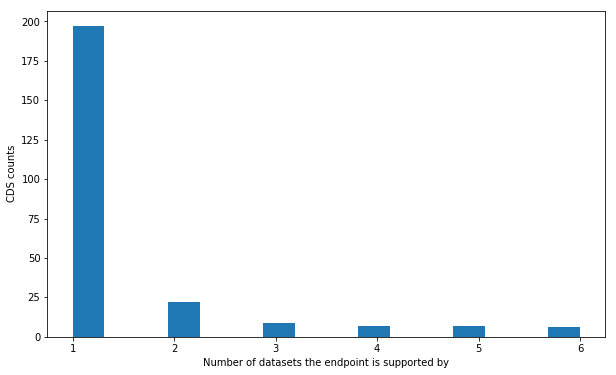

In [19]:
fig = plt.figure(figsize=(10,6))
hist = plt.hist(ndatasets, bins=16)
plt.ylabel("CDS counts")
plt.xlabel("Number of datasets the endpoint is supported by")

Text(0.5, 0, 'Number of reads the endpoint is supported by')

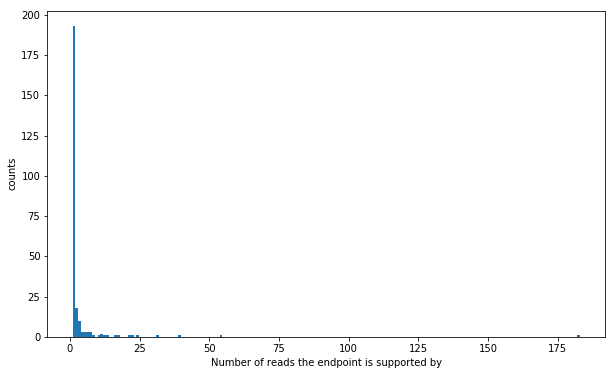

In [21]:
fig = plt.figure(figsize=(10,6))
hist = plt.hist(nmatchreads, bins=max(nmatchreads))
plt.ylabel("counts")
plt.xlabel("Number of reads the endpoint is supported by")

OK lets take a quick look to see which of these ends have helicos DRS support

In [22]:
from parsing_routines.wig_tools import wigData
DRS_fwd = wigData("../../supporting_datasets/Sherstnev2012_Helicos_Bio/fwd_wt1_HQ2.wig.gz")
DRS_rev = wigData("../../supporting_datasets/Sherstnev2012_Helicos_Bio/rev_wt1_HQ2.wig.gz")

In [23]:
nmatchpos=0
nrep=2000
ncount=0
counter=0
t0=time.time()
DRSpad=5
for thisregion in new_polyAstarts.keys():
    if "helicos_support" not in new_polyAstarts[thisregion].keys():
        new_polyAstarts[thisregion]["helicos_support"]=False
    
    if thisregion[3]=="-":
        DRS_data = DRS_rev
    else:
        DRS_data = DRS_fwd
    
    try:
        DRS_data.set_region("Chr{}".format(thisregion[0]), start=thisregion[1]-DRSpad,
                            stop=thisregion[2]+DRSpad)
        thisdata = DRS_data.get_region_data()
        if len(thisdata[1])>0:
            if numpy.any(thisdata[1]>3):
                new_polyAstarts[thisregion]["helicos_support"]=True
                nmatchpos+=1
    except ValueError:
        pass
    
    counter+=1
    if counter==nrep:
        ncount+=1
        print("Done {} ids in {:.2f}s".format(ncount*nrep, time.time()-t0))
        counter=0
        t0=time.time()

Done 2000 ids in 5.75s
Done 4000 ids in 4.16s
Done 6000 ids in 3.77s
Done 8000 ids in 3.37s
Done 10000 ids in 4.58s


Print out a few details...

In [24]:
ncorereg = 0
DRSsupport = []
for thisregion in new_polyAstarts.keys():
    if thisregion[0] in ['1','2','3','4','5']:
        ncorereg+=1
    if new_polyAstarts[thisregion]["helicos_support"]:
        DRSsupport.append(thisregion)

print("{} of the {} regions in the core genome have Helicos DRS support".format(len(DRSsupport), ncorereg))

15 of the 10623 regions in the core genome have Helicos DRS support


In [25]:
for thisregion in DRSsupport:
    thisdata = new_polyAstarts[thisregion]
    nreads = 0
    ndatasets = 0
    if "read_matches" in thisdata.keys():
        nreads = len(thisdata["read_matches"])
        ndatasets = len(numpy.unique(numpy.array(new_polyAstarts[thisregion]['read_matches'])[:,0]))
    print(thisregion, thisdata["tx_id"], thisdata["is_inTerminalExon"], thisdata["length"][0],
          thisdata['genomic_length'], nreads, ndatasets)

('1', 7920500, 7920835, '+') ['AT1G22430.2'] [(False, False)] 6 335 22 4
('1', 24058472, 24058600, '+') ['AT1G64770.3'] [(False, False)] 12 128 7 4
('2', 1823271, 1823277, '-') ['AT2G05100.2'] [(True, True)] 6 6 183 6
('2', 5907887, 5908228, '+') ['AT2G14045.3'] [(False, True)] 12 341 31 5
('2', 16464489, 16464855, '-') ['AT2G39435.2'] [(False, True)] 6 366 6 4
('3', 3051386, 3051393, '+') ['AT3G09922.1'] [(True, True)] 7 7 0 0
('4', 8694288, 8694517, '+') ['AT4G15233.2'] [(False, True)] 20 229 2 1
('4', 12820673, 12820691, '-') ['AT4G24920.2'] [(False, False)] 18 18 0 0
('5', 6355264, 6356354, '-') ['AT5G19025.1'] [(False, True)] 6 1090 1 1
('5', 6740609, 6740714, '+') ['AT5G19940.2'] [(False, True)] 7 105 39 6
('5', 7177256, 7177645, '+') ['AT5G21105.3'] [(False, True)] 6 389 54 6
('5', 7198835, 7199202, '-') ['AT5G21160.2'] [(False, True)] 11 367 17 5
('5', 7198835, 7198844, '-') ['AT5G21160.3'] [(True, True)] 9 9 5 3
('5', 21244907, 21245134, '-') ['AT5G52320.2'] [(False, True)] 6 